In [25]:
!pip install stable_baselines3
!pip install quantstats
!pip install gym_anytrading
!pip install bitfinex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 7.8 MB/s eta 0:00:01
  Created wheel for bitfinex: filename=bitfinex-0.2.6-py3-none-any.whl size=4130 sha256=32badde5b54baa5bd5ae41752abebfded0e095794d1ef0ea2f5a38612bf02866
  Stored in directory: /root/.cache/pip/wheels/1b/3e/e7/bd2594507cdc7c1a3327b3b716ad87ec448d20c4a0c78e698d
  Created wheel for httpretty: filename=httpretty-1.1.4-py3-none-any.whl size=28808 sha256=68e7e865885a5f49833983c24aa5ada0005064e754c49e07fddaf552c93e1e0d
  Stored in directory: /root/.cache/pip/wheels/d1/3a/37/230f8d6e3a966eb96133354ca98d986ffeccfd06dd6de96e58
Successfully 

In [2]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
from stable_baselines3 import A2C,PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.ppo import MlpPolicy
import matplotlib.pyplot as plt


In [3]:
# df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

# window_size = 10
# start_index = window_size
# end_index = len(df)

# env_maker = lambda: gym.make(
#     'stocks-v0',
#     df = df,
#     window_size = window_size,
#     frame_bound = (start_index, end_index)
# )

# env = DummyVecEnv([env_maker])

The *window_size* specifies how many previous timesteps our trading bot has as reference points when it makes its next trade. The *frame_bound* specifies the start and end of our df. The first parameter on the *frame_bound* should always be equal to the *window_size* so that it has the five sets of previous data. For the second parameter, you can adjust it to any value of your choice depending on your data.


In [27]:
import bitfinex
import datetime
import time
import pandas as pd

# Create api instance of the v2 API
api_v2 = bitfinex.api_v2()

# Define query parameters
pair = 'BTCUSD' # Currency pair of interest
TIMEFRAME = '1h'#,'4h','1h','15m','1m'

# Define the start date
t_start = datetime.datetime(2018, 9, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

# Define the end date
t_stop = datetime.datetime(2020, 10, 1, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

# Download OHCL data from API
result = api_v2.candles(symbol=pair, interval=TIMEFRAME, limit=1000, start=t_start, end=t_stop)

# Convert list of data to pandas dataframe
names = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume']
df = pd.DataFrame(result, columns=names)
df['Date'] = pd.to_datetime(df['Date'], unit='ms')

# we can plot our downloaded data
import matplotlib.pyplot as plt
plt.plot(df['Open'],'-')
plt.show()



AttributeError: module 'bitfinex' has no attribute 'api_v2'

In [22]:
def _process_data(df):


    prices = df.loc[:, 'Close'].to_numpy()

    frame_bound=(10, len(df)) # validate index (TODO: Improve validation)
    prices = prices[frame_bound[0]-10:frame_bound[1]]

    diff = np.insert(np.diff(prices), 0, 0)
    print(diff)
    signal_features = np.column_stack((prices, diff))

    return prices, signal_features

def my_process_data(df):
    frame_bound=(10, len(df))
    start = frame_bound[0] - 10
    end = frame_bound[1]
    prices = df.loc[:, 'Low'].to_numpy()[start:end]
    #customize your features here 
    signal_features = df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features
a, b = my_process_data(df)

In [4]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()
window_size = 10
start_index = window_size
end_index = len(df)

def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    #customize your features here 
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = my_process_data


env = MyForexEnv(df=STOCKS_GOOGL, window_size=10, frame_bound=(10, len(STOCKS_GOOGL)))


![alt text](https://miro.medium.com/max/1400/0*9KP9fMyqHfQs2tD3 "title")



We will briefly introduce some "beautiful" parts of PPO. 

The upcoming proximal policy optimization (PPO) algorithm tries to
mimic the constrained TRPO problem based on related unconstrained
problems.

\begin{array}{ll} 
& \boldsymbol{\theta}_{k+1}=\underset{\boldsymbol{\theta}}{\arg \max } \mathbb{E}_{\pi_{\boldsymbol{\theta}_k}}\left[\frac{\pi_{\boldsymbol{\theta}}(\boldsymbol{U} \mid \boldsymbol{X})}{\pi_{\boldsymbol{\theta}_k}(\boldsymbol{U} \mid \boldsymbol{X})} a_{\pi_k}(\boldsymbol{X}, \boldsymbol{U})\right], \\
\text { s.t. } \quad & \mathbb{E}_{\pi_{\boldsymbol{\theta}_k}}\left[D_{\mathrm{KL}}\left(\pi_{\boldsymbol{\theta}_k}(\cdot \mid \boldsymbol{X}) \| \pi_{\boldsymbol{\theta}}(\cdot \mid \boldsymbol{X})\right)\right] \leq \kappa .
\end{array}


Here we will explain the constraint term: <font color=yellow> metric describing how much a policy is changed in the action space
when updating the policy in the parameter space. And $ \kappa $ limits the average KL
（Kullback-Leibler
divergence (also called relative entropy) ) divergence w.r.t. the states
visited by the old policy</font>.


Hence, the objective will be reformulated to incorporate mechanisms 
**preventing excessively large variations** of the policy distribution during
a parameter update (leading to an updated policy with sufficient
proximity to the old one).

PPO incorporates  variants which we will discuss: Clipping the surrogate objectiv.

   <br/>

Background of [TRPO](https://spinningup.openai.com/en/latest/algorithms/trpo.html#background)


##### Clipped Surrogate Objective

$\mathbb{E}_{\pi_{\boldsymbol{\theta}_k}}\left[\min \left\{\frac{\pi_{\boldsymbol{\theta}}(\boldsymbol{U} \mid \boldsymbol{X})}{\pi_{\boldsymbol{\theta}_k}(\boldsymbol{U} \mid \boldsymbol{X})} a_{\pi_k}(\boldsymbol{X}, \boldsymbol{U}), \operatorname{clip}\left(\frac{\pi_{\boldsymbol{\theta}}(\boldsymbol{U} \mid \boldsymbol{X})}{\pi_{\boldsymbol{\theta}_k}(\boldsymbol{U} \mid \boldsymbol{X})}, 1-\epsilon, 1+\epsilon\right) a_{\pi_k}(\boldsymbol{X}, \boldsymbol{U})\right\}\right]$

 Above, ϵ < 1 is a PPO hyperparameter serving as a regularizer.

 The first element of min{·} is the previous TPRO objective.

 The second element of min{·} modifies the surrogate objective by
clipping the importance sampling ratio π<sub>θ<sub/>/π<sub>θ<sub>k</sub></sub>
.

 The latter should remove the incentive for moving the importance
sampling ratio outside of the interval [1 − ϵ, 1 + ϵ].

 The modified objective is therefore a lower bound of the unclipped
TRPO objective.

*<font color=red>Interpretation: the new policy does not benefit from going further
away from the old policy.</font>*

In [9]:


model = PPO(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 571  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------


### General Idea of How agent trading


After the agent is trained, it should be able to trade the stock
<center> Logic behind Trading  </center> 

```
class Actions(Enum):
    Sell = 0
    Buy = 1


class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True
```

The stock could be sold only if agent believe the price would decrease and position = 1, which means agent has already bought stock. Similarly, agent will buy stock when the predicted price would increase and agent has no stock.
On the other hand, if agent predicts an uptrend and position = 1 (has stock), then agent take no action.

<br/>   
<center> Reward and Profit </center>

```
step_reward = 0
if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Short:
                step_reward += -price_diff * 10000
            elif self._position == Positions.Long:
                step_reward += price_diff * 10000

        return step_reward
```
For every trade agent made, the rewawrd is defined by the difference between
the prices between the current time and last trading time.
<br/>

```

            if self.unit_side == 'left':
                if self._position == Positions.Short:
                    quantity = self._total_profit * (last_trade_price - self.trade_fee)
                    self._total_profit = quantity / current_price

            elif self.unit_side == 'right':
                if self._position == Positions.Long:
                    quantity = self._total_profit / last_trade_price
                    self._total_profit = quantity * (current_price - self.trade_fee)
```
*unit_side* : Specifies the side you start your trading. Containing string values of left (default value) and right. As you know, there are two sides in a currency pair in FOREX. For example in the EUR/USD pair, when you choose the left side, your currency unit is EUR and you start your trading with 1 EUR.

The rule of calculating profit might be tricky, which requires some finance knowledge.
Agent makes profit from shorting the stock. For example, agent borrows a share of stock from dealer with price 10 pound and return it back to the dealer with price 9 pound. The profit is 1 pound (excluding the trading fee). On the other word, agent makes profit when price of stock decreasing


In [6]:
#env = env_maker()
observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break


info: {'total_reward': -5967109.60000002, 'total_profit': 0.28173442160691065, 'position': 1}


For the figure below, red for Short and green for Long

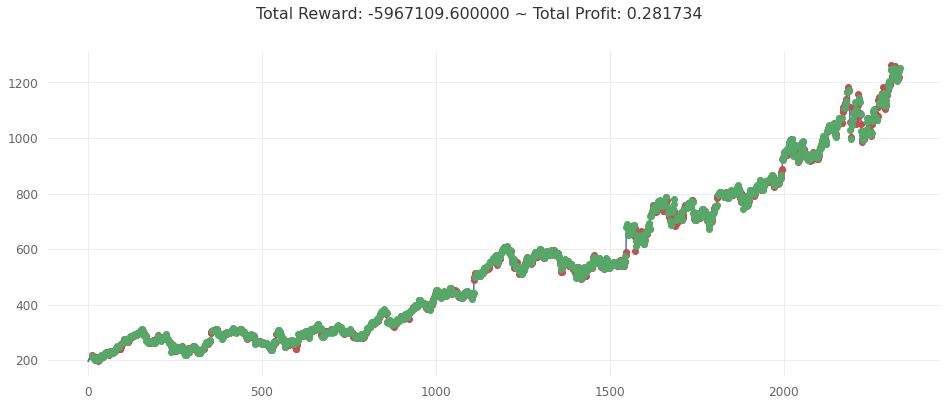

In [7]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

### Metric Explaination


**Cumulative Return** : A cumulative return on an investment is the aggregate amount that the investment has gained or lost over time, independent of the amount of time involved.
<br/>

**Sharpe** : the Sharpe ratio  measures the performance of an investment such as a security or portfolio compared to a risk-free asset, after adjusting for its risk.

**Maximum Drawdown** : A maximum drawdown (MDD) is the maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained. Maximum drawdown is an indicator of downside risk over a specified time period.
Intuitively, that's the lowest point on the Cumulative Return figure.





[Performance Metrics]



                    Strategy
------------------  ----------
Start Period        2009-06-10
End Period          2018-08-29
Risk-Free Rate      0.0%
Time in Market      25.0%

Cumulative Return   -72.32%
CAGR﹪              -13.0%

Sharpe              -0.78
Prob. Sharpe Ratio  0.82%
Sortino             -1.06
Sortino/√2          -0.75
Omega               0.75

Max Drawdown        -75.08%
Longest DD Days     2975

Gain/Pain Ratio     -0.25
Gain/Pain (1M)      -0.44

Payoff Ratio        1.09
Profit Factor       0.75
Common Sense Ratio  0.52
CPC Index           0.33
Tail Ratio          0.7
Outlier Win Ratio   19.93
Outlier Loss Ratio  2.31

MTD                 2.55%
3M                  -10.23%
6M                  -12.66%
YTD                 -13.84%
1Y                  -17.82%
3Y (ann.)           -17.37%
5Y (ann.)           -15.3%
10Y (ann.)          -13.0%
All-time (ann.)     -13.0%

Avg. Drawdown       -21.16%
Avg. Drawdown Days  666
Recovery Factor     -0.96
Ulcer Index         0.46
Serenit

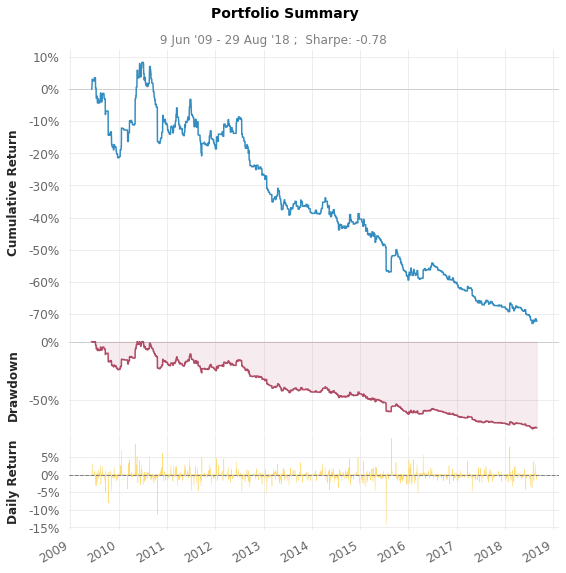

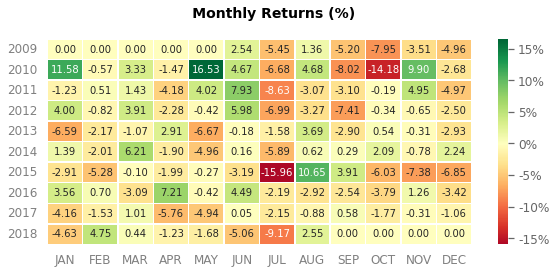

In [8]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index + 1 :end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.basic(returns)